<a href="https://colab.research.google.com/github/Kimeteor309/Financial-big-data-analysis/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90_week3%E4%BD%9C%E6%A5%AD_%E6%8A%80%E8%A1%93%E5%88%86%E6%9E%90%E8%88%87K%E7%B7%9A%E5%9C%96%E9%A1%9E%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **取得股價資料**

In [64]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# 將民國年轉換為西元年
def convert_to_gregorian(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)  # 民國年轉換為西元年
    return f'{year}/{month}/{day}'

# 從台灣證券交易所 API 獲取每日收盤價
def get_twse_data(stock_id, date):
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_id}"
    response = requests.get(url)
    data = response.json()

    # 解析 JSON 並轉換為 DataFrame
    columns = data['fields']
    rows = data['data']
    df = pd.DataFrame(rows, columns=columns)

    # 將日期轉換為西元年
    df['日期'] = df['日期'].apply(convert_to_gregorian)
    df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')  # 指定西元年格式

    # 只保留你需要的欄位，並重新命名為英文字段
    df = df[['日期', '開盤價', '最高價', '最低價', '收盤價', '成交股數']].copy()
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # 將數值欄位轉為數字類型，並去除逗號
    df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''))
    df['High'] = pd.to_numeric(df['High'].str.replace(',', ''))
    df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''))
    df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''))
    df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''))

    return df

# 獲取一段日期範圍內的股價資料
def get_data_range(stock_id, start_year, start_month, end_month):
    all_data = pd.DataFrame()  # 用於存放所有月份的數據
    for month in range(start_month, end_month + 1):
        # 日期格式：YYYYMMDD，只需要指定月份的第一天
        date = f"{start_year}{month:02d}01"
        df_month = get_twse_data(stock_id, date)
        all_data = pd.concat([all_data, df_month], ignore_index=True)  # 合併時確保索引正確

    return all_data

# 取得台積電從4月至9月的股價資料
stock_id = '2330'  # 台積電股票代號
df = get_data_range(stock_id, 2024, 4, 9)

# 顯示資料
df

,Date,Open,High,Low,Close,Volume
0,2024-04-01,783.0,783.0,769.0,770.0,22348250
1,2024-04-02,784.0,790.0,783.0,790.0,42219075
2,2024-04-03,783.0,785.0,778.0,780.0,32909892
3,2024-04-08,789.0,792.0,783.0,783.0,40567580
4,2024-04-09,795.0,820.0,792.0,819.0,61642573
...,...,...,...,...,...,...
118,2024-09-23,971.0,977.0,971.0,977.0,15399658
119,2024-09-24,976.0,987.0,971.0,987.0,29324170
120,2024-09-25,1000.0,1005.0,998.0,1005.0,43039991
121,2024-09-26,1010.0,1015.0,1005.0,1015.0,43341810


# **1. 計算技術指標（SMA、RSI、MACD）**


## 1.1 計算簡單移動平均線（SMA）

In [65]:
# 計算8日 SMA
df['8_SMA'] = df['Close'].rolling(window=8).mean()

# 計算13日 SMA
df['13_SMA'] = df['Close'].rolling(window=13).mean()

# 計算20日 SMA
df['20_SMA'] = df['Close'].rolling(window=20).mean()

# 列印最後筆數
df.tail()

,Date,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA
118,2024-09-23,971.0,977.0,971.0,977.0,15399658,948.250,930.615385,936.45
119,2024-09-24,976.0,987.0,971.0,987.0,29324170,959.000,938.153846,938.30
120,2024-09-25,1000.0,1005.0,998.0,1005.0,43039991,967.125,946.076923,941.45
121,2024-09-26,1010.0,1015.0,1005.0,1015.0,43341810,975.625,953.538462,944.00
122,2024-09-27,1020.0,1025.0,1000.0,1000.0,37665070,982.250,961.307692,946.85


## 1.2 計算相對強弱指數（RSI）

<img src="https://images.stockfeel.com.tw/stockfeelimage/2015/10/%E6%95%99%E4%BD%A0%E7%9C%8B%E6%87%82-RSI-%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%A8%99-01.jpg" alt="rsi" width="500"/>
<img src="https://images.stockfeel.com.tw/stockfeelimage/2015/10/%E6%95%99%E4%BD%A0%E7%9C%8B%E6%87%82-RSI-%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%A8%99-02.jpg" alt="rs" width="500"/>

**RSI 的計算步驟如下：**

**1. 變動計算 (Change)：**計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異。

**2. 增益與損失：**將變動中的正數部分計為增益（Gain），負數部分計為損失（Loss），並將它們取為正值或 0。

**3. 平均增益與損失：**使用滾動窗口（14天）來計算過去14天的平均增益和平均損失。

**4. 計算 RSI：**計算相對強度（RS）作為平均增益和平均損失的比值，最後根據 RSI 公式計算 RSI。


In [66]:
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df['Change'] = df['Close'] - df['Close'].shift(1)

# 將變動值中的正數部分視為“Gain”（增益），如果變動為負則記為0
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為“Loss”（損失），取其絕對值，如果變動為正則記為0
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)

df.tail()

# 計算過去14個交易日的平均增益
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度（RS），即平均增益與平均損失的比值
df['RS'] = df['Avg Gain'] / df['Avg Loss']

# 計算相對強弱指數（RSI），使用RS公式計算出來
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 顯示最後幾行的數據
df.tail()

,Date,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
118,2024-09-23,971.0,977.0,971.0,977.0,15399658,948.250,930.615385,936.45,4.0,4.0,0.0,8.285714,6.214286,1.333333,57.142857
119,2024-09-24,976.0,987.0,971.0,987.0,29324170,959.000,938.153846,938.30,10.0,10.0,0.0,9.000000,5.642857,1.594937,61.463415
120,2024-09-25,1000.0,1005.0,998.0,1005.0,43039991,967.125,946.076923,941.45,18.0,18.0,0.0,10.285714,2.000000,5.142857,83.720930
121,2024-09-26,1010.0,1015.0,1005.0,1015.0,43341810,975.625,953.538462,944.00,10.0,10.0,0.0,10.071429,2.000000,5.035714,83.431953
122,2024-09-27,1020.0,1025.0,1000.0,1000.0,37665070,982.250,961.307692,946.85,-15.0,0.0,15.0,8.928571,3.071429,2.906977,74.404762


## 1.3 計算平滑異同移動平均線（MACD）

要計算移動平均收斂發散指數（MACD），首先需要計算以下幾個關鍵指標：

1. 8天的指數平滑移動平均線（EMA_8）。
2. 13天的指數平滑移動平均線（EMA_13）。
3. MACD 線：8天 EMA 減去 13天 EMA。

---
補充：常見的標準 MACD 使用 12日和 26日 EMA，適合較中長期的趨勢分析。而 8日和 13日 EMA 的組合則更加適合短期的波動。



In [67]:
# 計算8天的指數移動平均線（EMA），並將其存儲在 'EMA_8' 列中
# adjust=False 表示在計算 EMA 時，只考慮當前值和前一個 EMA 的遞歸計算方式，而不考慮所有歷史數據
df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()

# 計算13天的指數移動平均線（EMA），並將其存儲在 'EMA_13' 列中
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()

# 計算MACD線：8天EMA減去13天EMA，並將其存儲在 'MACD' 列中
df['MACD'] = df['EMA_8'] - df['EMA_13']

# 顯示DataFrame的最後幾行數據
df.head(3)

,Date,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
0,2024-04-01,783.0,783.0,769.0,770.0,22348250,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,770.000000,770.000000,0.000000
1,2024-04-02,784.0,790.0,783.0,790.0,42219075,NaN,NaN,NaN,20.0,20.0,0.0,NaN,NaN,NaN,NaN,774.444444,772.857143,1.587302
2,2024-04-03,783.0,785.0,778.0,780.0,32909892,NaN,NaN,NaN,-10.0,0.0,10.0,NaN,NaN,NaN,NaN,775.679012,773.877551,1.801461


# **2. 可視化 K 線圖**

## 2.1 可視化收盤價折線圖

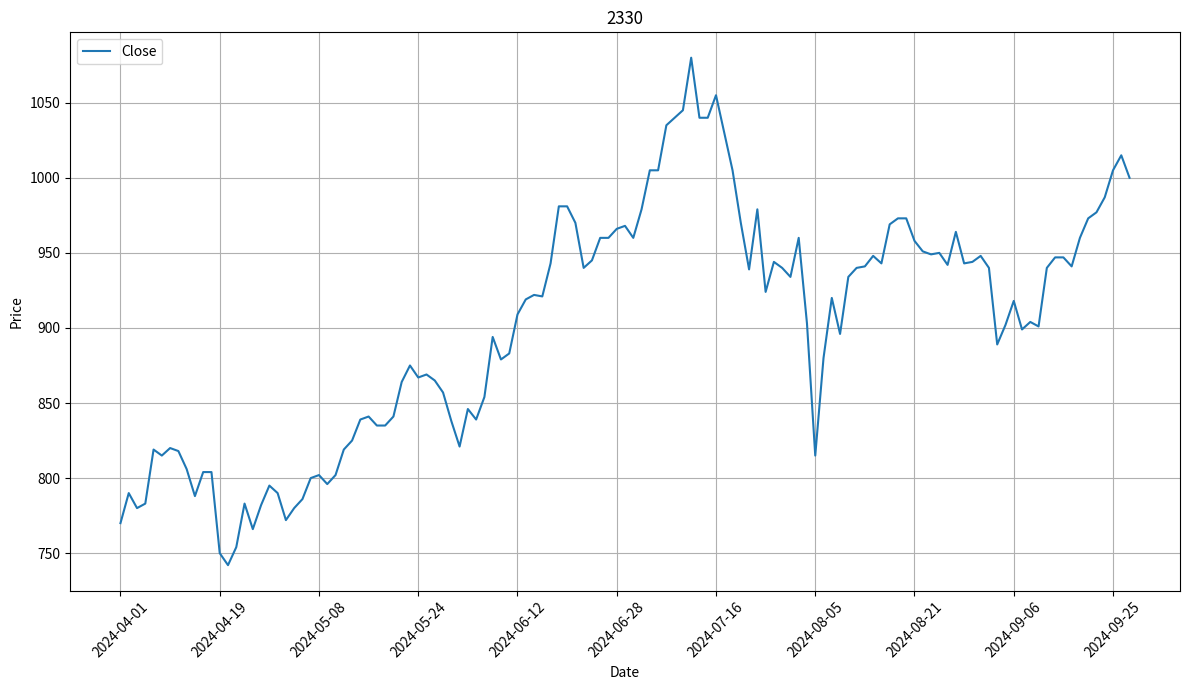

In [68]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(date)//num
           date[::len(date)//num],  # 設定顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(date)//num
           rotation = 45) # 讓日期標籤旋轉 45 度，以避免標籤之間重疊，提高可讀性

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

## 2.2 加入技術指標

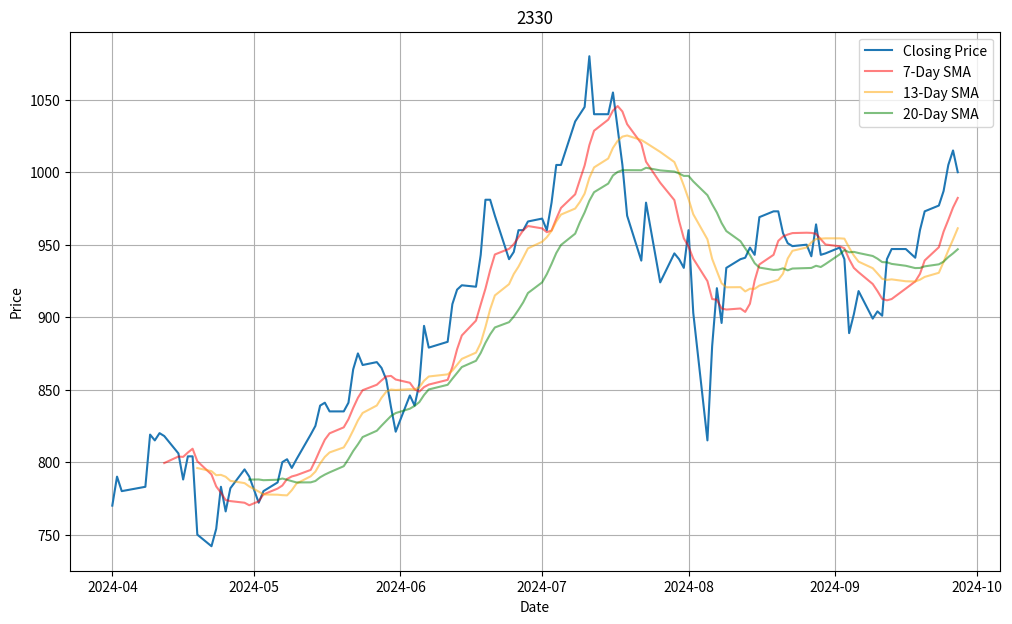

In [69]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Date'], df['Close'], label='Closing Price')

# 8 天的 SMA
plt.plot(df['Date'], df['8_SMA'], label='7-Day SMA', color='red', alpha=.5)

# 13 天的 SMA
plt.plot(df['Date'], df['13_SMA'], label='13-Day SMA', color='orange', alpha=.5)

# 20 天的 SMA
plt.plot(df['Date'], df['20_SMA'], label='20-Day SMA', color='green', alpha=.5)

# 將股票代號設為圖標
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

## 2.3 K 線

In [70]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


In [71]:
# 將原始的 dataframe 再建立一個出來
kplot_df = df.set_index('Date')
kplot_df['2024-8-01':'2024-09-18'].tail()

,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
Date,,,,,,,,,,,,,,,,,,
2024-09-11,906.0,906.0,900.0,901.0,19513256,912.625,926.461538,938.00,-3.0,0.0,3.0,4.428571,8.000000,0.553571,35.632184,912.528220,920.382034,-7.853815
2024-09-12,936.0,944.0,928.0,940.0,43749260,911.625,925.692308,937.85,39.0,39.0,0.0,7.214286,7.857143,0.918182,47.867299,918.633060,923.184601,-4.551541
2024-09-13,955.0,955.0,939.0,947.0,28307441,912.500,926.076923,936.75,7.0,7.0,0.0,7.642857,7.857143,0.972727,49.308756,924.936824,926.586801,-1.649976
2024-09-16,952.0,952.0,943.0,947.0,14456888,919.750,924.769231,935.45,0.0,0.0,0.0,7.642857,7.285714,1.049020,51.196172,929.839752,929.502972,0.336780
2024-09-18,945.0,948.0,933.0,941.0,30094662,924.625,924.615385,933.85,-6.0,0.0,6.0,6.071429,7.714286,0.787037,44.041451,932.319807,931.145405,1.174403


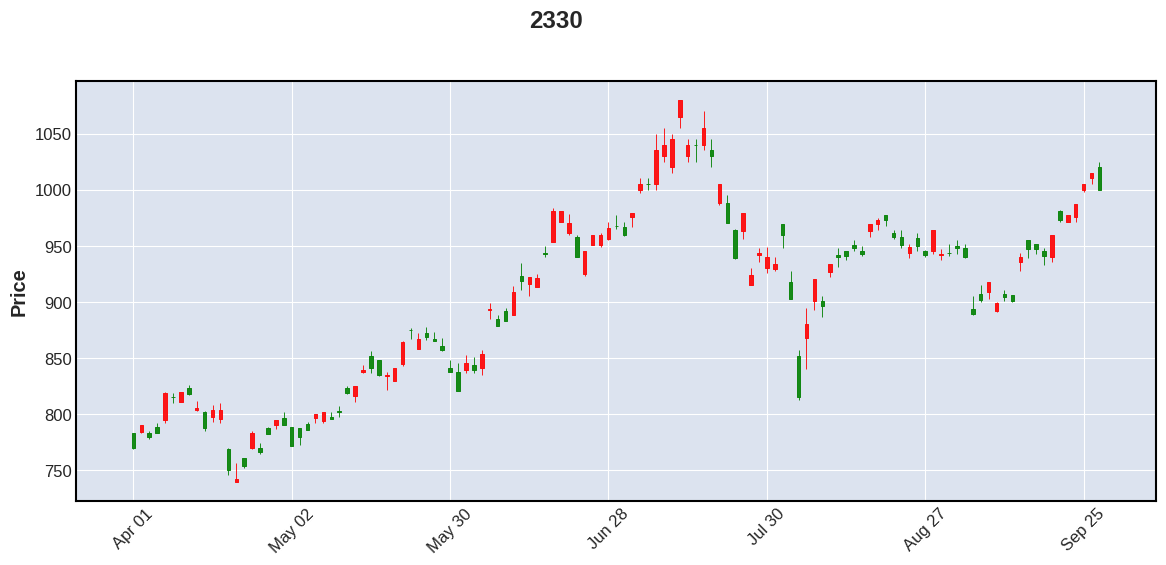

In [72]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

## 2.4 捕捉 Hammer 型態
錘形線（Hammer）

<img src="https://drive.google.com/uc?id=1M5t0g5kKCm2xfzRaFHfKt_CT41XSRjgb" alt="drawing" width="600"/>

In [73]:
# 計算 K 線長度 = abs(收盤-開盤)
df['body_length'] = abs(df['Close'] - df['Open'])

# 計算下影線長度 = abs(最高-最小)
df['lower_shadow'] = abs(df['Low'] - df[['Open', 'Close']].min(axis=1))

# 計算上影線長度 = abs(最高-最小)
df['upper_shadow'] = abs(df['High'] - df[['Open', 'Close']].max(axis=1))

# 定義 Hammer 型態的條件
hammer_condition = (
    (df['lower_shadow'] > 2 * df['body_length']) &  # 下影線長於實體的两倍
    (df['upper_shadow'] < df['body_length'] * 0.1) &  # 上影線很短
    (df['body_length'] < (df['High'] - df['Low']) * 0.4)  # 實體相對較小
)

# 提取 Hammer 型態
hammer_df = df[hammer_condition]
hammer_df.set_index('Date', inplace=True)

hammer_df

,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-03,976.0,979.0,967.0,979.0,25022531,959.75,959.538462,936.7,19.0,19.0,...,7.857143,3.571429,2.2,68.75,962.391305,952.063502,10.327803,3.0,9.0,0.0


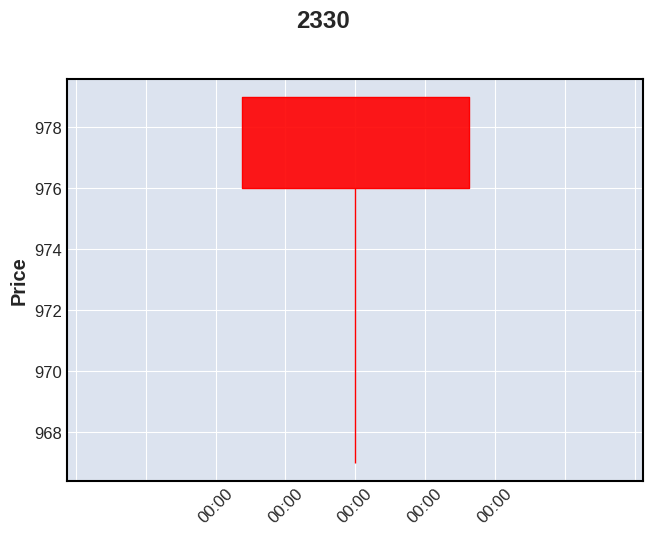

In [74]:
mpf.plot(hammer_df, type='candle', style=my_style, title=f'{stock_id}')

## 2.5 捕捉 Doji 型態
十字線（Doji）

<img src="https://drive.google.com/uc?id=1BDfcn8ZmMVgl0Xlku7mSD338WHeffrgc" alt="drawing" width="600"/>

In [75]:
# 計算 K 線長度
df['body_length'] = abs(df['Close'] - df['Open'])

# 定義Doji型態的條件
# 一般來說，body 長度 如果 小於等於 (最高價-最低價) * 0.1
doji_condition = (
    df['body_length'] <= (df['High'] - df['Low']) * 0.1  # 中間區域非常小
)

# 提取Doji形态
doji_df = df[doji_condition]
doji_df.set_index('Date', inplace=True)

doji_df

,Open,High,Low,Close,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-10,815.0,819.0,810.0,815.0,31109466,NaN,NaN,NaN,-4.0,0.0,...,NaN,NaN,NaN,NaN,792.888753,786.234843,6.653911,0.0,5.0,4.0
2024-05-20,834.0,838.0,822.0,835.0,30148330,824.000,810.153846,797.20,0.0,0.0,...,5.357143,2.500000,2.142857,68.181818,825.137466,816.308513,8.828952,1.0,12.0,3.0
2024-05-23,875.0,877.0,867.0,875.0,40771207,844.375,828.769231,812.25,11.0,11.0,...,7.642857,0.857143,8.916667,89.915966,845.067422,833.124312,11.943110,0.0,8.0,2.0
2024-06-06,893.0,899.0,885.0,894.0,67300344,851.750,856.153846,846.30,40.0,40.0,...,8.714286,4.500000,1.936508,65.945946,856.932448,851.141697,5.790750,1.0,8.0,5.0
2024-06-18,944.0,950.0,940.0,943.0,40870419,908.750,882.153846,875.30,22.0,22.0,...,10.357143,4.785714,2.164179,68.396226,909.337320,894.505534,14.831786,1.0,3.0,6.0
2024-07-01,968.0,977.0,965.0,968.0,20936005,961.250,952.000000,924.00,2.0,2.0,...,9.071429,3.000000,3.023810,75.147929,956.973382,945.503100,11.470282,0.0,3.0,9.0
2024-07-05,1005.0,1010.0,1000.0,1005.0,21735614,975.375,970.769231,949.80,0.0,0.0,...,9.500000,3.500000,2.714286,73.076923,979.224370,966.107879,13.116491,0.0,5.0,5.0
2024-07-15,1040.0,1045.0,1025.0,1040.0,44123104,1036.250,1009.461538,992.15,0.0,0.0,...,10.214286,3.428571,2.979167,74.869110,1032.129414,1015.014231,17.115183,0.0,15.0,5.0
2024-08-29,942.0,947.0,937.0,943.0,46275772,953.750,954.153846,934.60,-21.0,0.0,...,4.785714,4.142857,1.155172,53.600000,950.751921,949.570518,1.181404,1.0,5.0,4.0


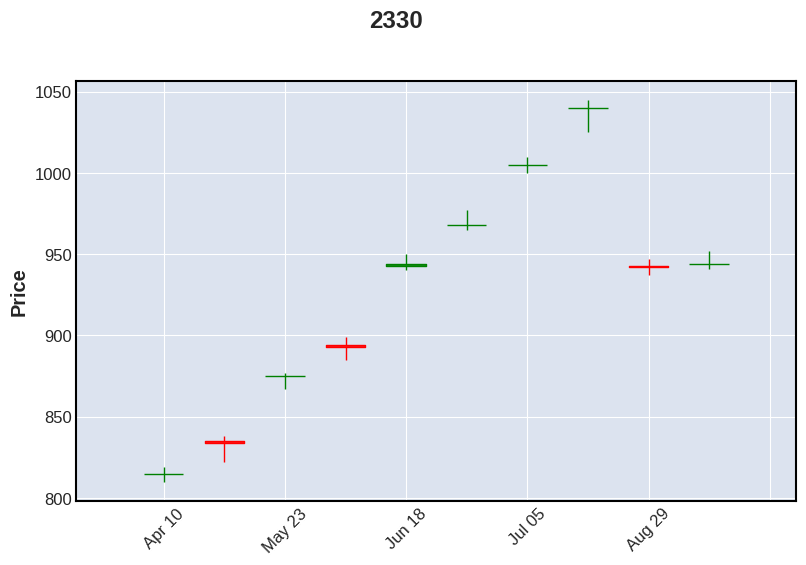

In [76]:
mpf.plot(doji_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(10, 6))

# **3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價**

技術指標當特徵，用線性回歸、決策樹、隨機森林預測股價漲跌

## 3.1 資料前處理

In [77]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [78]:
# 標籤生成: 預測未來1天的價格，這裡以2024-04-01的技術指標 預測隔天的收盤價
n = 1
df['Future_Price'] = df['Close'].shift(-n)

# 去除缺失值
df.dropna(inplace=True)

# 使用特徵
X = df[['20_SMA', 'RSI', 'MACD']]

# 標籤（未來價格）
y = df['Future_Price']

X.shape, y.shape

((103, 3), (103,))

In [79]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 3), (21, 3), (82,), (21,))

## 3.2 線性回歸（Linear Regression）

In [80]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 23.67
線性回歸模型預測未來1天的價格: 998.77


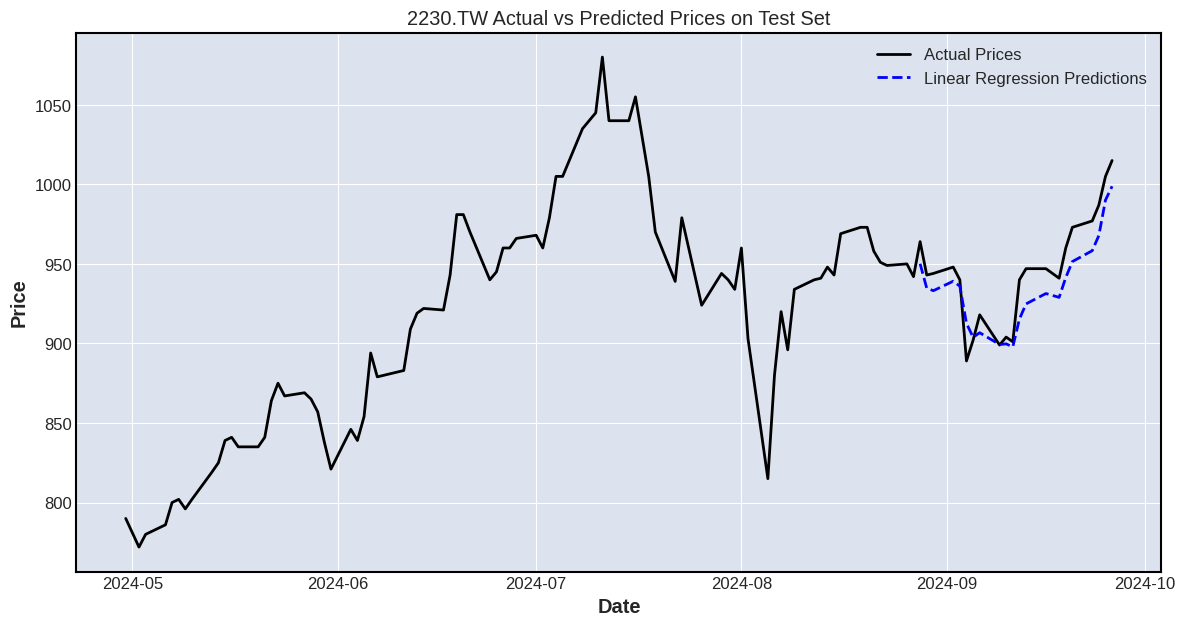

In [81]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Linear Regression Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.2 決策樹（Decision Tree）

In [82]:
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策數模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"決策樹模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"決策樹模型預測未來{n}天的價格: {future_pred[0]:.2f}")

決策樹模型RMSE: 40.26
決策樹模型預測未來1天的價格: 1035.00


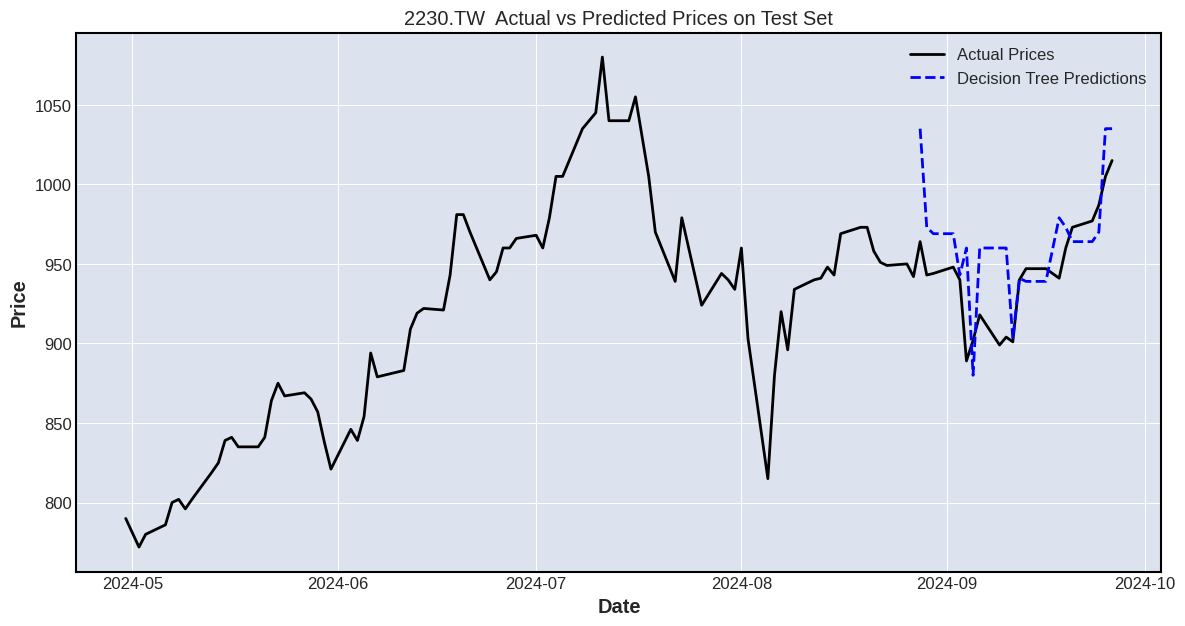

In [83]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Decision Tree Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.3 隨機森林（Random Forest）

In [86]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練決策數模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 28.44
隨機森林模型預測未來1天的價格: 1016.54


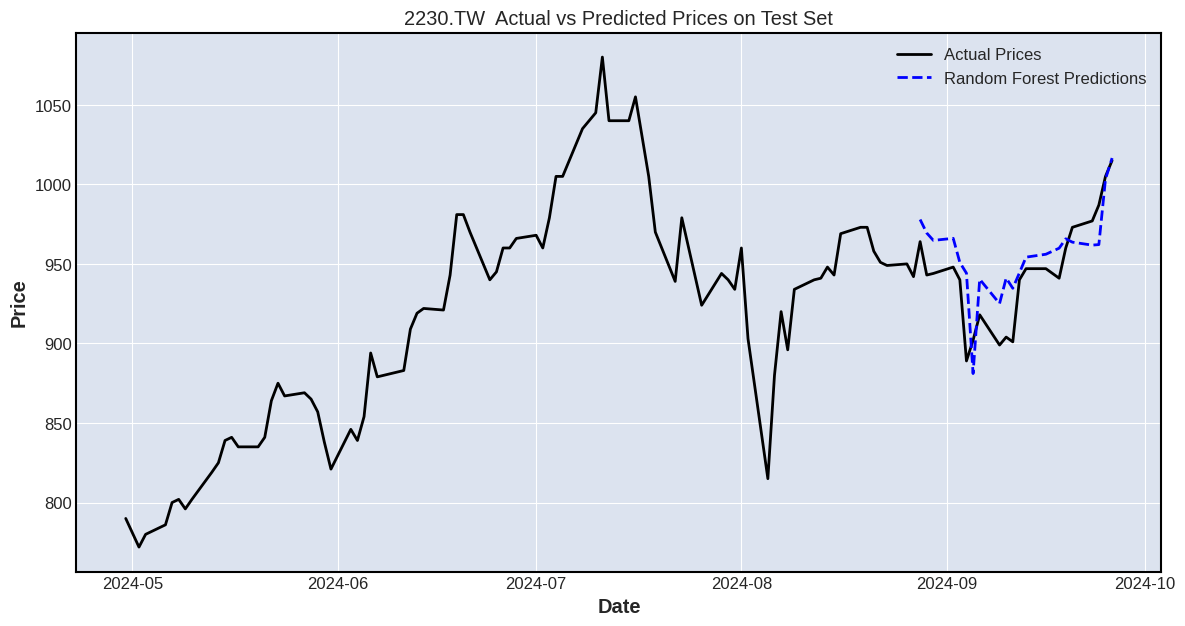

In [87]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# **補充：在 Colab 上使用中文字體**

In [89]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-09-28 09:03:15--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.196.101, 74.125.196.100, 74.125.196.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.196.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-09-28 09:03:15--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-09-28 09:03:

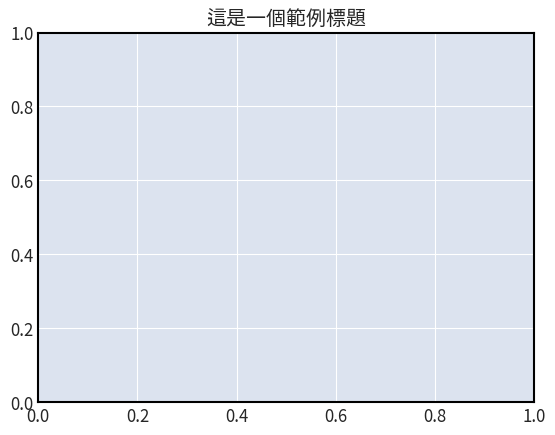

In [90]:
# 繪製範例圖表
plt.title("這是一個範例標題")
plt.show()

# **Pandas Shift**

In [94]:
sample_df = pd.DataFrame({
    'Date': ['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06'],
    'SMA': ['SMA_1', 'SMA_2', 'SMA_3', 'SMA_4', 'SMA_5', 'SMA_6'],
    'RSI': ['RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6'],
    'MACD': ['MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6'],
    'Close': [111, 222, 333, 444, 555, 666]
})
sample_df

,Date,SMA,RSI,MACD,Close
0,2024-02-01,SMA_1,RSI_1,MACD_1,111
1,2024-02-02,SMA_2,RSI_2,MACD_2,222
2,2024-02-03,SMA_3,RSI_3,MACD_3,333
3,2024-02-04,SMA_4,RSI_4,MACD_4,444
4,2024-02-05,SMA_5,RSI_5,MACD_5,555
5,2024-02-06,SMA_6,RSI_6,MACD_6,666


In [95]:
sample_df['Future_Close'] = sample_df['Close'].shift(-1)
sample_df

,Date,SMA,RSI,MACD,Close,Future_Close
0,2024-02-01,SMA_1,RSI_1,MACD_1,111,222.0
1,2024-02-02,SMA_2,RSI_2,MACD_2,222,333.0
2,2024-02-03,SMA_3,RSI_3,MACD_3,333,444.0
3,2024-02-04,SMA_4,RSI_4,MACD_4,444,555.0
4,2024-02-05,SMA_5,RSI_5,MACD_5,555,666.0
5,2024-02-06,SMA_6,RSI_6,MACD_6,666,NaN
